# **Transient Filtering Demo Notebook**

### Cristina Andrade (andra104@umn.edu) and Shar Daniels (shard@udel.edu)

**Notebook Author:** Cristina Andrade

**LSST Science Collaboration Fast Transient Sub-group Coordinator:** Shar Daniels  

**Google Colab link:** https://colab.research.google.com/drive/1qZFYctt6lM5dg9z_W_Jo38rVxmlW2wuf?usp=sharing

---

In this notebook, you will be guided through a demonstration of the process of evaluating how well an astronomical survey cadence will detect rapidly-evolving transient phenomena.

---

## Understanding Rubin’s Survey Cadences

The **Vera C. Rubin Observatory** will carry out a 10-year optical survey of the sky called the Legacy Survey of Space and Time (LSST). But how the sky is observed: when, where, and in which filters is not fixed. Instead, Rubin’s team designs and tests different cadence strategies to maximize scientific return across a wide range of priorities: supernovae, asteroids, gravitational wave counterparts, and more. One of these cadences will execute the LSST.

Each cadence is a simulated 10-year observing plan that specifies:

* How frequently each patch of sky is revisited,

* Which filters are used in each visit (ugrizy),

* The depth and timing of those observations.

Rubin’s operations team maintains a public cadence repository with names like `baseline_v2.0` or `rolling_v4.3.1`, each representing a different trade-off. Some prioritize uniform sky coverage. Others emphasize short revisit times or deeper exposures.

In this notebook, we’ll use a simplified version of these cadences to test how different observing strategies affect our ability to detect and characterize fast transients like kilonovae. Understanding how Rubin surveys the sky is key to designing metrics that reveal which cadences perform best for your science.

**To begin, please install and import the packages in the cells below.**

In [ ]:
%pip install healpy
%pip install dustmaps

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, GeocentricTrueEcliptic
import astropy.units as u
from itertools import product
import ipywidgets as widgets
from IPython.display import display, Markdown
from astropy.cosmology import Planck18 as cosmo
import pickle
import os
import matplotlib.colors as mcolors

In [ ]:
from dustmaps.sfd import SFDQuery
from dustmaps.config import config
config.reset()

from dustmaps.config import config
config['data_dir'] = './'

import dustmaps.sfd
dustmaps.sfd.fetch()

#**Cadences**

Let's take a look at Rubin's cadence maps.

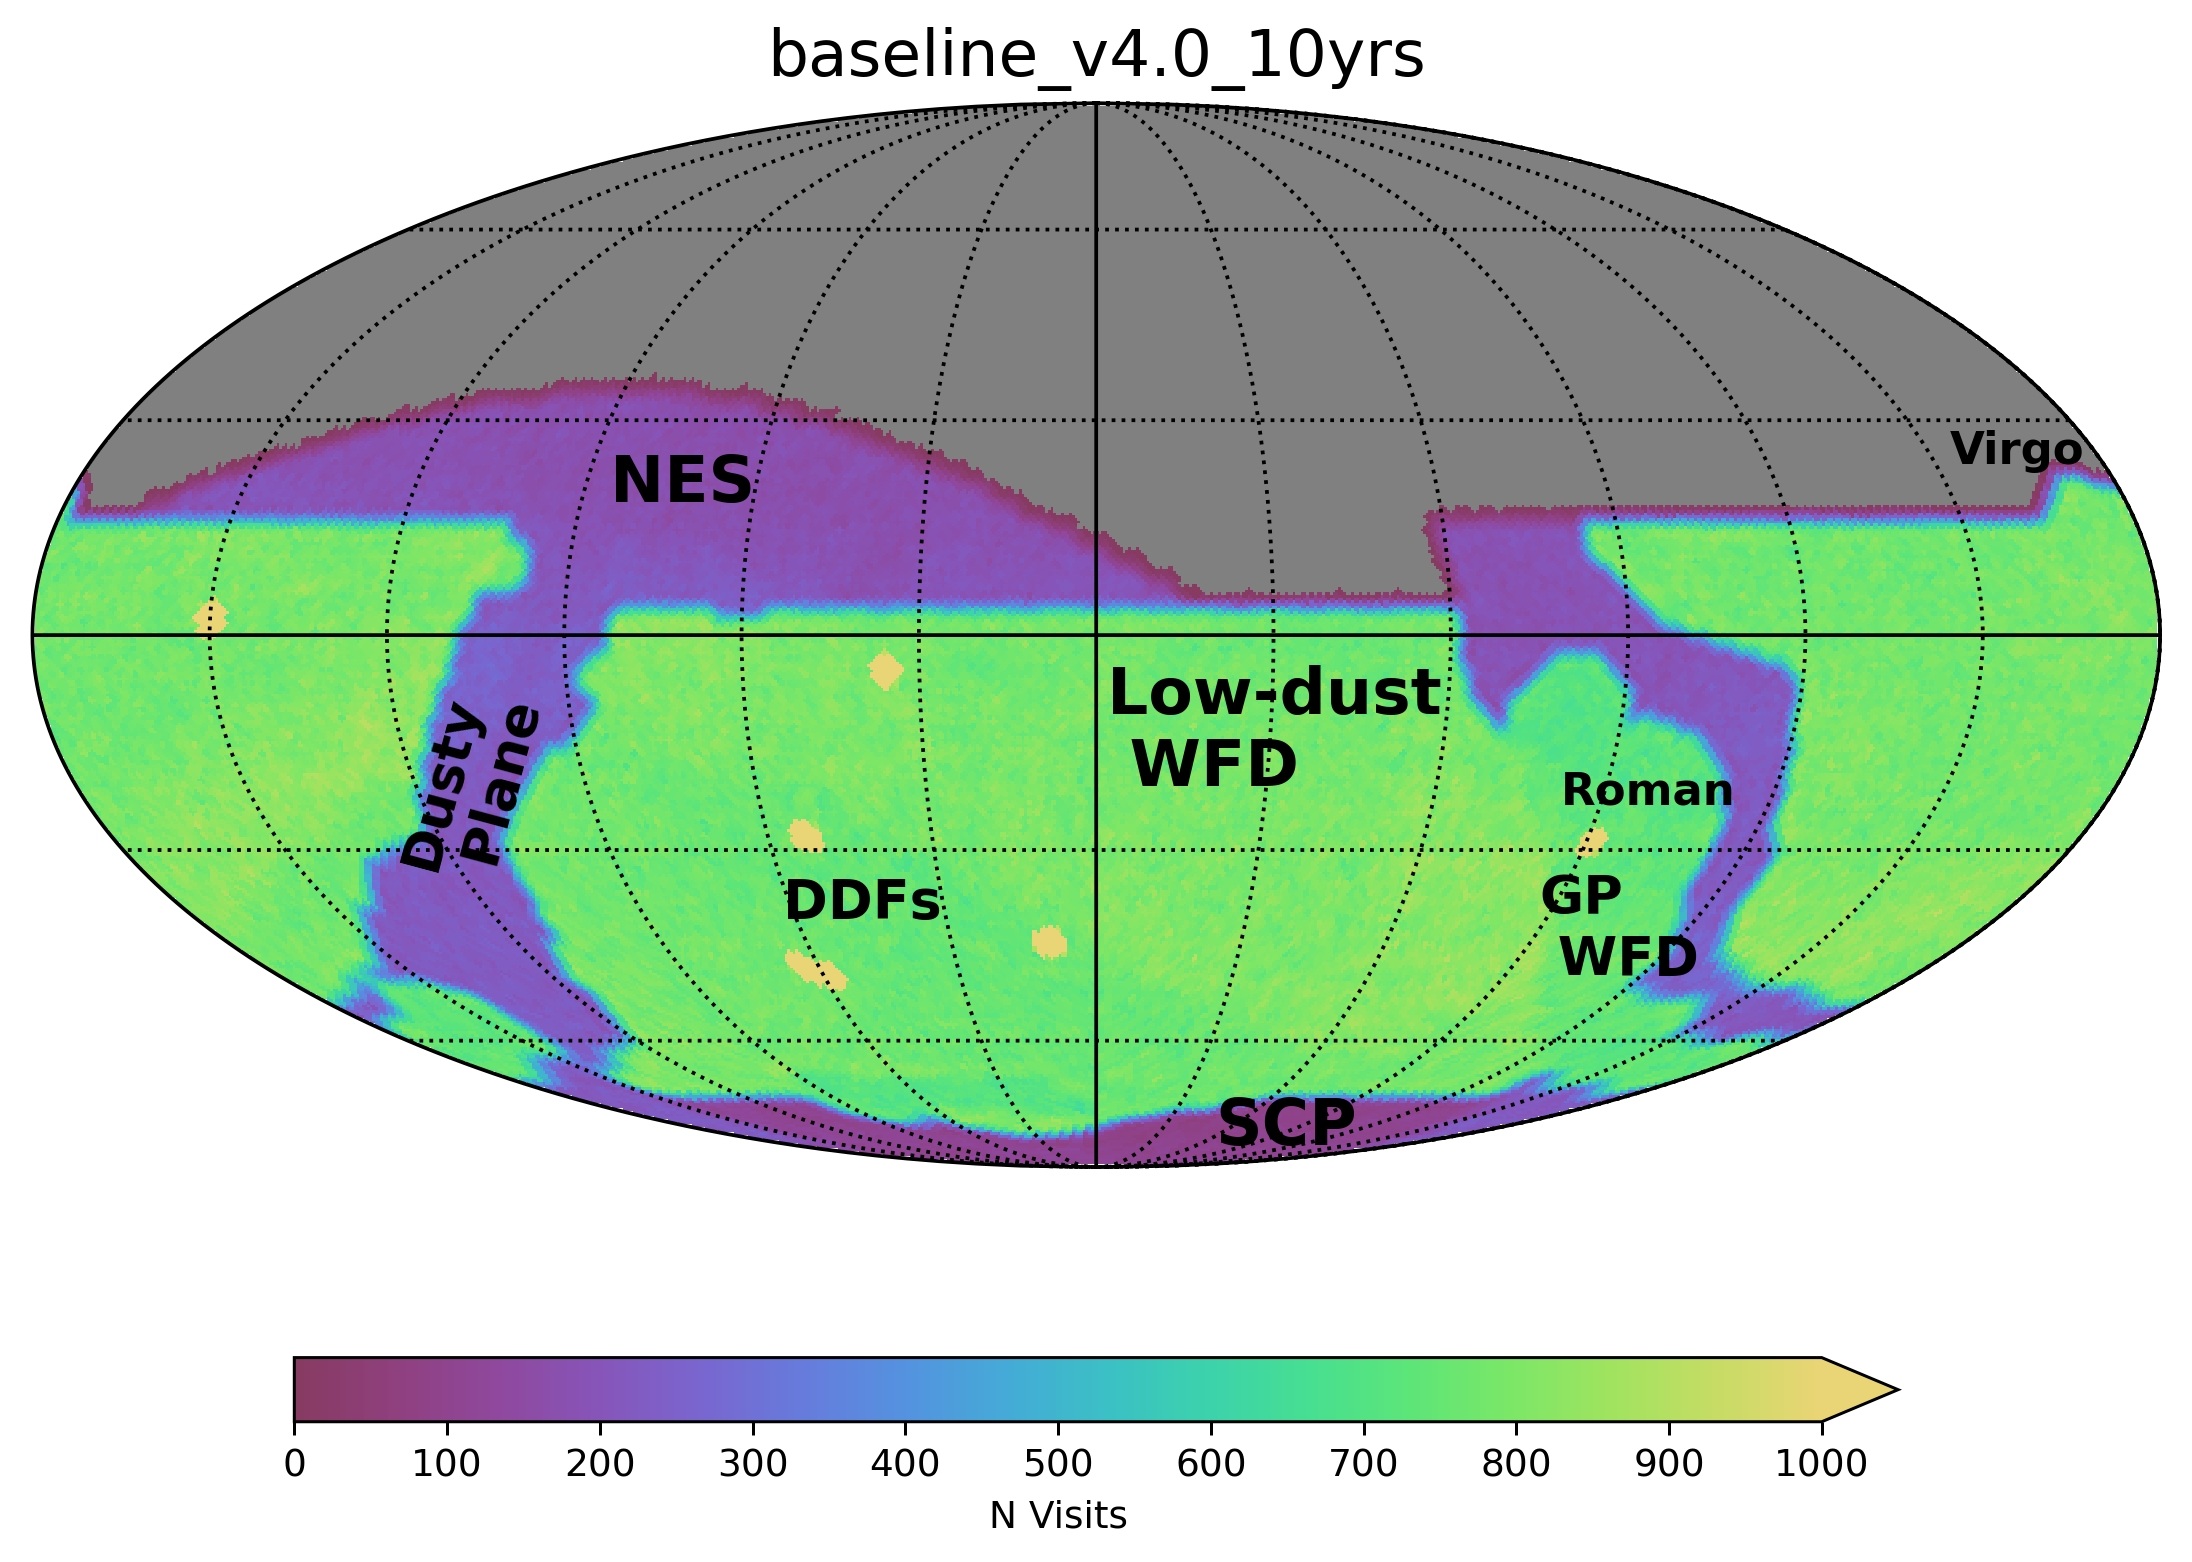

#**What Are Survey Cadences?**

A cadence refers to how and when a telescope revisits the same area of the sky over time and in which filters. Cadences determine the spacing between observations, the depth of each exposure, and the balance across filters. Ultimately, this controls whether a transient event is detected, followed up, or missed entirely.

**Rubin’s Baseline Cadence: Wide, Deep, and Evolving**
The LSST survey strategy is structured around a baseline cadence, designed to optimize a wide range of science goals. The key components include:

**Wide-Fast-Deep (WFD):** The main survey, covering most of the extragalactic sky with ∼80% of the survey time. It achieves broad area coverage, regular revisits, and depth sufficient for faint transient detection.

**Deep Drilling Fields (DDFs):** Small fields (∼10 deg² each) that are observed with high cadence and depth—up to 1 mag deeper than WFD—to capture detailed light curves. They receive ~6–7% of survey time.

**Mini- and Micro-surveys:** Specialized observations (e.g. the Galactic Plane or South Celestial Pole), contributing 3–10% and 1–3% of the survey time, respectively.

**Target of Opportunity (ToO):** Rapid-response observations triggered by external alerts (e.g. gravitational waves or gamma-ray bursts), accounting for ~3% of the time.

**Baseline Evolution: v4.0 to v4.3.1+**
Rubin's baseline cadence evolves regularly as pre-commissioning simulations improve. These updates consider new scheduler algorithms, weather data, and science priorities. For example:

**v4.0 began in May 2025;** v4.3.1 adjusted the start date to November 2025 for realism, added new u/g-band timing logic, and incorporated minor schema corrections.

The **triplet survey mode**, introduced in v3.0–3.2, enforces three visits within one night for a small percent of visits to better capture rapidly-evolving transients.

**U-band strategy** has been a consistent point of optimization: balancing shorter exposures (e.g. 30s in v3.0) against longer but fewer visits (e.g. 38s in v3.6) to improve sensitivity to early blue emission in events like kilonovae.

Rolling cadences are used to prioritize different sky regions at different times, allowing more rapid of sampling while maintaining uniformity on longer scales.

Each version affects transient recovery differently. For instance, a cadence that increases observations in the blue bands helps capture the fast, early light from kilonovae, while one that favors deep DDF revisits improves characterization.

**Why This Matters**
The cadence defines what Rubin can see, when, and how well. A fast transient like a kilonova might be visible for just a few days in some filters. The cadence needs to land observations in that window—with enough frequency, filter coverage, and depth—for us to detect it and reconstruct its light curve.

The ZTF Transient Filtering Demo uses these cadence concepts to test how different strategies perform in recovering realistic kilonova events. By applying detection metrics to each simulated cadence, we learn which observing strategies maximize our scientific return.

#**1. Simulated Survey Cadence on the Sky**

---
We'll generate a simplified Rubin-like cadence using randomized observation times across a Healpix grid of the southern sky. This helps us explore how survey strategy impacts transient recovery.

This simulation sets the foundation for the entire filtering pipeline: it determines when and where the sky is observed, which limits when transient events can be detected. The cadence affects revisit time, temporal gaps, and multi-filter coverage. All of which shape our ability to detect fast transients.

---

## PART A: Generate a Rubin-like mock cadence over the southern sky

---
**Run the cell below.**

DO NOT edit the cell below just yet.

Read below and try to complete the exercises in Part B first.

This cell generates a baseline cadence over the southern sky.

You will be asked to replicate and extend parts of this logic in the next section.

---



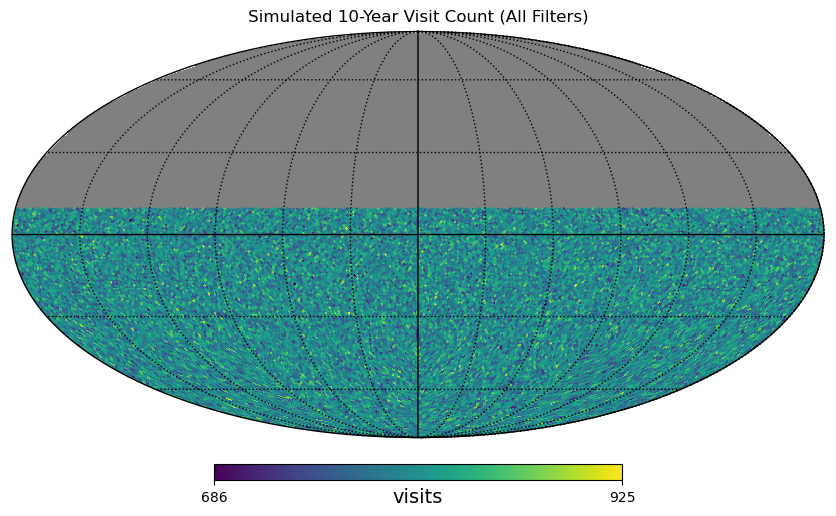

Saved mock cadence to 'mock_cadence.pkl'.


In [2]:
# Define sky resolution
nside = 64
npix = hp.nside2npix(nside)

# Simulate southern sky coverage (Dec < 10 deg)
th, ph = hp.pix2ang(nside, np.arange(npix))
dec = np.degrees(0.5 * np.pi - th)
sky_mask = dec < 10  # Southern sky only

# Survey setup
years = 10
filters = ['u', 'g', 'r', 'i', 'z', 'y']
obs_per_year = {
    'u': 5, 'g': 10, 'r': 20, 'i': 20, 'z': 15, 'y': 10  # Rubin v4.3.1 approximations
}

mock_cadence = {f: [] for f in filters}
mock_mjds = {f: [] for f in filters}
pixel_obs_times = {f: {} for f in filters}  # Added for downstream use

rng = np.random.default_rng(42)  # reproducibility

# Create container with pixel indices as top-level keys
pixel_obs_times = {}

for f in filters:
    for y in range(years):
        mjd_start = 60980.5 + y * 365.25
        for pix in np.where(sky_mask)[0]:
            n_visits = rng.poisson(obs_per_year[f])
            if n_visits > 0:
                times = rng.uniform(mjd_start, mjd_start + 365.25, size=n_visits)
                mock_cadence[f].append((pix, n_visits))
                mock_mjds[f].append((pix, times))

                if pix not in pixel_obs_times:
                    pixel_obs_times[pix] = {}
                if f not in pixel_obs_times[pix]:
                    pixel_obs_times[pix][f] = times
                else:
                    pixel_obs_times[pix][f] = np.concatenate([pixel_obs_times[pix][f], times])

# Sort the MJD times
for pix in pixel_obs_times:
    for f in pixel_obs_times[pix]:
        pixel_obs_times[pix][f] = np.sort(pixel_obs_times[pix][f])

# Compute total visit map (all filters)
visit_map = np.zeros(npix)
for f in filters:
    for pix, n in mock_cadence[f]:
        visit_map[pix] += n
visit_map[~sky_mask] = hp.UNSEEN

# Plot total visit count
hp.mollview(visit_map, title='Simulated 10-Year Visit Count (All Filters)', unit='visits', cmap='viridis')
hp.graticule()
plt.show()

# Save cadence map for downstream use (SNR calc, injection)
with open('mock_cadence.pkl', 'wb') as f:
    pickle.dump(pixel_obs_times, f)
print("Saved mock cadence to 'mock_cadence.pkl'.")

## CHALLENGE: Simulating 5σ Depth Variability (r-band, Year 3)

---
Rubin’s cadence is not uniform across all filters or years. Some regions get more r- and i-band coverage. Different years also see different cadences.

The depth of a given observation, meaning the faintest detectable magnitude for that observation, varies due to sky brightness, seeing, airmass, and weather. Rubin’s expected depths per visit are:

- g, r: ~24.7 mag
- i, z: ~24.0–24.5 mag
- y: ~23.3 mag

---
The 5σ depth is the faintest magnitude that Rubin can detect with high confidence in a single visit. But this depth is not constant—it depends on observing conditions like sky brightness, airmass, and seeing. In some places and years, Rubin will reach deeper (detect fainter objects); in others, it won’t.

This exercise helps visualize that variability by simulating it for a specific filter (r-band) during a specific year (Year 3).

---

**Instructions:**

Use the mock_mjds dictionary to simulate 5σ depth variability for the r-band in Year 3.

1. Extract observation times in r-band for the correct year.
2. Count how many r-band visits each pixel received in Year 3.
3. For each pixel, simulate 5σ limiting depths using a Gaussian (mean=24.7, sigma=0.3).
4. Save the *median* depth for each pixel to a Healpix map.
5. Visualize the depth map using hp.mollview().

This simulates how sky brightness, seeing, and weather lead to variability in detection depth.

---

In [3]:
mock_mjds['r'][0][1].shape

(17,)

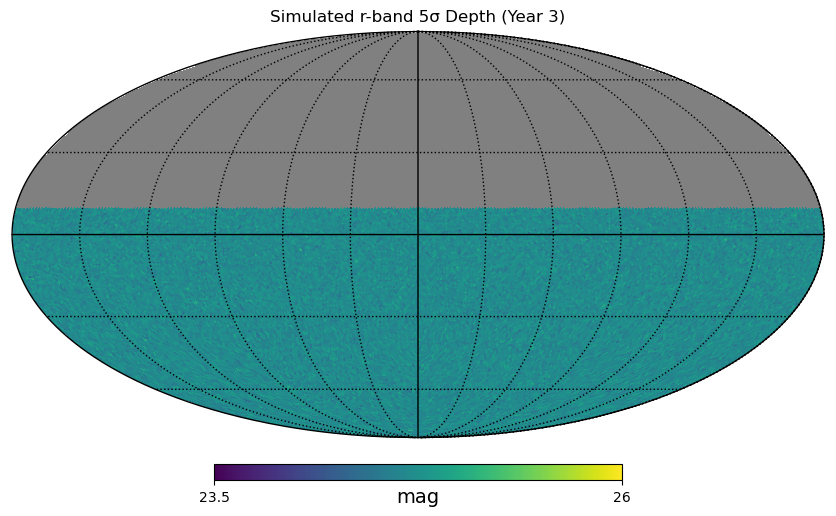

In [4]:
# YOUR WORK HERE
# Define year index
year_index = 2  # Year 3

# Create empty Healpix maps
depth_map = np.full(npix, hp.UNSEEN)
visit_counts = np.zeros(npix)

# TODO: Loop through mock_mjds['r']
for pix, times in mock_mjds['r']:

    year_start = 60980.5 + year_index * 365.25
    year_end = 60980.5 + (year_index+1) * 365.25

    year_times = times[(times>=year_start) & (times<year_end)]
    n_visits = len(year_times)

    if n_visits>0:
        visit_counts[pix] = n_visits
        depths = rng.normal(loc=24.7, scale=0.3, size=n_visits)
        depth_map[pix] = np.median(depths)

# Plot median depth in r-band for Year 3
hp.mollview(depth_map, title='Simulated r-band 5σ Depth (Year 3)', unit='mag', cmap='viridis', min=23.5, max=26.0)
hp.graticule()
plt.show()

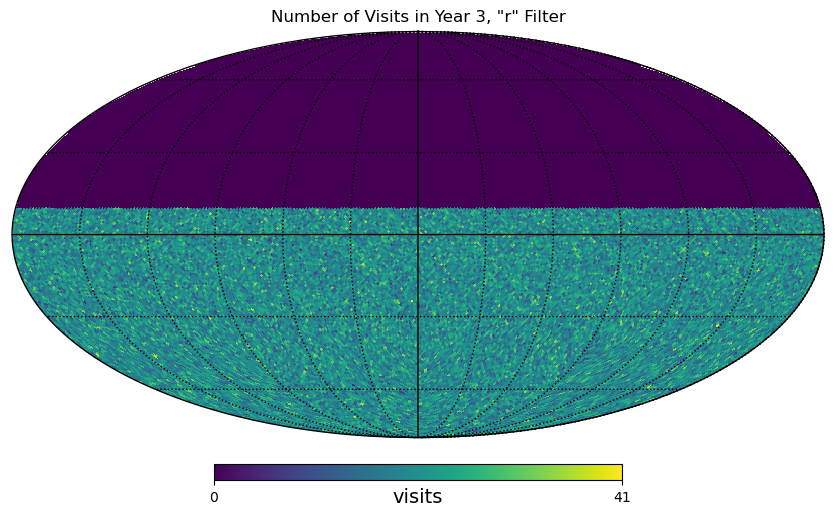

In [5]:
hp.mollview(visit_counts, title='Number of Visits in Year 3, "r" Filter', unit='visits', cmap='viridis')
hp.graticule()
plt.show()

<details>
<summary> SOLUTION </summary>

```python
# Focus on r-band, Year 3
year_index = 2  # Year 3
depth_map = np.full(npix, hp.UNSEEN)
visit_counts = np.zeros(npix)

for pix, times in mock_mjds['r']:
    times_in_year = times[(times >= 60980.5 + year_index * 365.25) &
                          (times < 60980.5 + (year_index + 1) * 365.25)]
    n_visits = len(times_in_year)
    if n_visits > 0:
        visit_counts[pix] = n_visits
        simulated_depths = rng.normal(loc=24.7, scale=0.3, size=n_visits)
        depth_map[pix] = np.median(simulated_depths)  # could also test mean or min

# Plot median depth in r-band for Year 3
hp.mollview(depth_map, title='Simulated r-band 5σ Depth (Year 3)', unit='mag', cmap='viridis', min=23.5, max=26.0)
hp.graticule()
plt.show()


### **Explanation:**
A simplified cadence map lets us test how different areas of the sky are sampled over time. By visualizing the number of observations per pixel (especially in different filters and across survey years), we can understand where and when transient signals might be recoverable. As well, where survey limitations are likely to suppress detection. This makes the cadence map a core input to any realistic transient filtering pipeline.

Fast transients like kilonovae often fade below detection thresholds quickly. Whether Rubin detects them can depend on exactly how deep the survey reached at the time of the event.

This simulation shows that:

* Cadence isn’t just about when we observe;

* It’s also about how well we observe - i.e., the quality of each visit.

By mapping depth across the sky, we can start to identify regions and time periods where detection is more likely, and where transient science is disadvantaged.


---
---

> **Discussion**: What differences do you notice between the full 10 year survey and year 3? Do you think the survey is "uniform" (and what does that mean to you)?

### Ecliptic Plane (|β| > 10°)

The **ecliptic plane** is the path the Sun traces through the sky over the course of a year, closely aligned with the orbital plane of the Earth and the major planets. This region—centered on **ecliptic latitude β = 0°**—is often crowded with Solar System objects (e.g., asteroids, comets, KBOs), and suffers from high background due to scattered sunlight and zodiacal light.

- **Cutting |β| > 10°** removes the ±10° band around the ecliptic.
- This helps exclude areas with high contamination from moving objects and bright sky background.
- It is a common practice for extragalactic or transient searches to avoid spurious detections or photometric noise in the ecliptic zone.

---

### Galactic Plane (|b| > 15°)

The **galactic plane** is the dense, flattened disk of the Milky Way galaxy, defined by **galactic latitude b = 0°**. This region contains a high concentration of stars, dust, and nebulae.

- **Cutting |b| > 15°** excludes the central ±15° strip around the Milky Way midplane.
- This removes regions with **high stellar density and extinction**, which can obscure faint extragalactic or fast optical transients.
- The cut improves detection efficiency and reduces confusion for surveys focused on extragalactic science (e.g., kilonovae, GRB afterglows).

---

These sky cuts are commonly used in Rubin simulations to **define clean extragalactic fields**, where transient detection is less hindered by foreground stars, dust extinction, or solar system objects.


#**2. Spatial Constraints and Sky Masking**

We'll mask out areas like the Galactic Plane to replicate follow-up and photometric challenges in dense fields. This highlights how spatial masking and observation timing varying across the map affects transient detectability.

Rubin and ZTF often exclude crowded or dust-obscured fields from transient follow-up (especially for faint, fast-evolving sources). Galactic plane masking is one common example.

---

## PART A: Applying a Galactic Plane Mask

In wide-field surveys like Rubin or ZTF, regions near the Galactic plane suffer from high stellar density and Milky Way extinction. This lowers the contrast and detectability of faint transients, increases source confusion, and limits spectroscopic follow-up.

Thus, Rubin follow-up programs often avoid fields near |b| < 15°.

We’ll apply a **Healpix-based Galactic latitude mask** and show how it reshapes our survey coverage.

This uses the `visit_map` from Section 1, which contains the total number of visits per pixel.

---




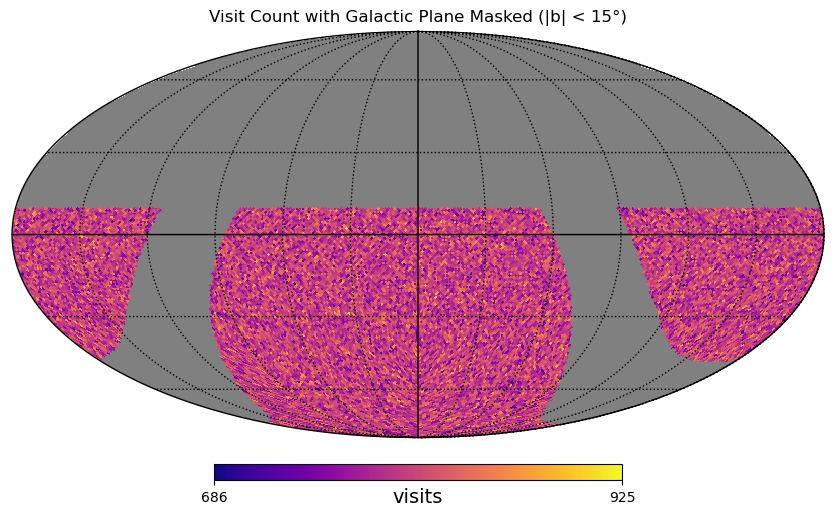

In [6]:
# RUN THIS CELL

# Use nside from Section 1
pix_indices = np.arange(npix)
th, ph = hp.pix2ang(nside, pix_indices)
ra = np.degrees(ph)
dec = np.degrees(0.5 * np.pi - th)

# Convert to Galactic coordinates
sky_coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
gal_lat = sky_coords.galactic.b.deg

# Apply Galactic plane mask: exclude |b| < 15 deg
galactic_mask = np.abs(gal_lat) >= 15

# Apply mask to visit map
masked_visits = np.copy(visit_map)
masked_visits[~galactic_mask] = hp.UNSEEN

# Plot masked visit count map
hp.mollview(masked_visits, title="Visit Count with Galactic Plane Masked (|b| < 15°)", unit='visits', cmap='plasma')
hp.graticule()
plt.show()



## Part A Context:

Masking |β| < 15 degrees mimics real-world limitations in Rubin transient filtering:

* Dense star fields increase background noise and source confusion

* Crowded fields challenge photometry pipelines

* Extinction reduces contrast for faint transients like KNe or GRB afterglows

You'll revisit this logic when generating your synthetic transient population and computing detection efficiency later on.

> **Discussion**: Why does the sky map have the shape that it does? What does it mean to "mask" an array in your code?

# PART B: Challenge Prompt

**Challenge Activity:**

Modify the galactic plane mask to instead exclude:
1. The ecliptic plane (|β| < 10 degrees), or
2. Pixels with very low visit counts (e.g. fewer than 50 total visits over 10 years).

This exercise explores alternative masking strategies, such as:

* To avoid solar system object contamination (ecliptic)

* To simulate LSST’s sparse edge-of-survey regions (low coverage)

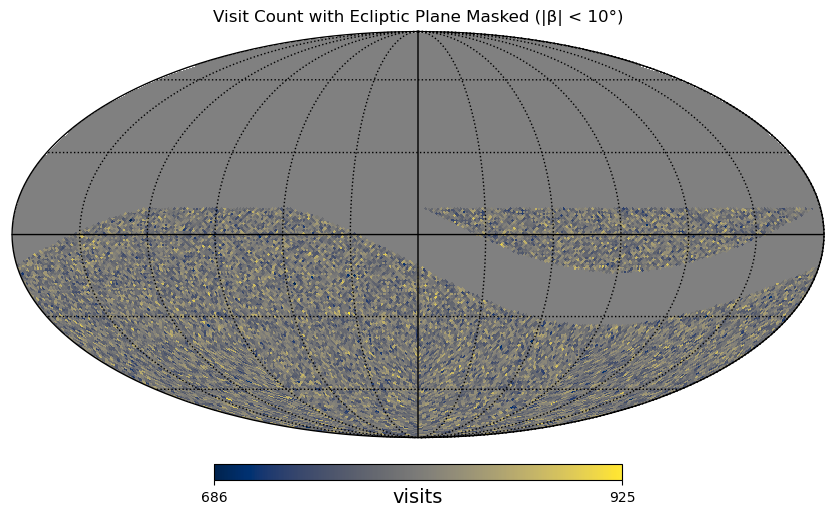

In [7]:
# YOUR CODE HERE

# Reuse RA/Dec and visit_map from Section 1
pix_indices = np.arange(npix)
th, ph = hp.pix2ang(nside, pix_indices)
ra = np.degrees(ph)
dec = np.degrees(0.5 * np.pi - th)

sky_coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

## Ecliptic Mask
ecl_coords = sky_coords.transform_to(GeocentricTrueEcliptic())
eclip_lat = ecl_coords.lat.deg
ecliptic_mask = np.abs(eclip_lat) >= 10
masked_ecliptic_map = np.copy(visit_map) # Apply copy to visit map
masked_ecliptic_map[~ecliptic_mask] = hp.UNSEEN # Apply mask to visit map

hp.mollview(masked_ecliptic_map,
            title="Visit Count with Ecliptic Plane Masked (|β| < 10°)",
            unit='visits', cmap='cividis')
hp.graticule()
plt.show()



<details>
<summary> SOLUTION </summary>

```python
# Mask the ecliptic plane (|β| < 10°)
ecl_coords = sky_coords.transform_to(GeocentricTrueEcliptic())
eclip_lat = ecl_coords.lat.deg
ecliptic_mask = np.abs(eclip_lat) >= 10

masked_ecliptic_map = np.copy(visit_map)
masked_ecliptic_map[~ecliptic_mask] = hp.UNSEEN

hp.mollview(masked_ecliptic_map,
            title="Visit Count with Ecliptic Plane Masked (|β| < 10°)",
            unit='visits', cmap='cividis')
hp.graticule()
plt.show()
```

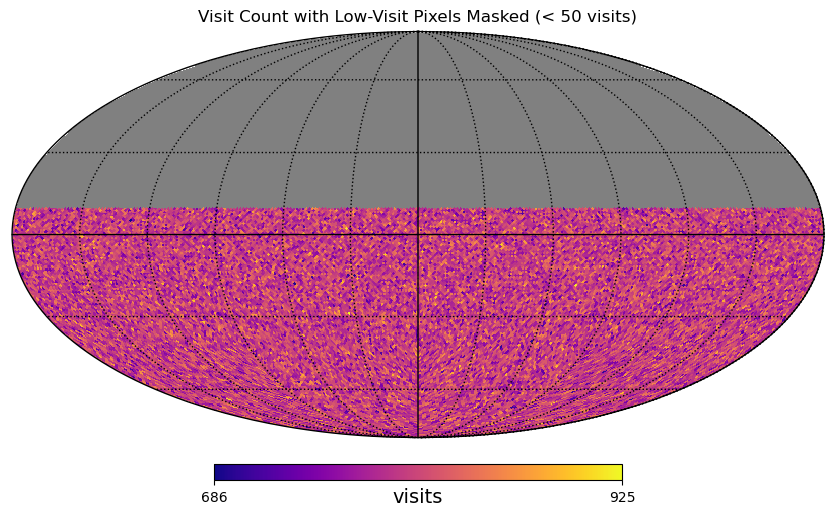

In [8]:
# YOUR WORK HERE


# 2. Mask pixels with < 50

low_visit_mask = np.abs(visit_map) >= 50
masked_low_visit_map = np.copy(visit_map)
masked_low_visit_map[~low_visit_mask] = hp.UNSEEN

hp.mollview(masked_low_visit_map,
            title="Visit Count with Low-Visit Pixels Masked (< 50 visits)",
            unit='visits', cmap='plasma')
hp.graticule()
plt.show()

<details>
<summary> SOLUTION </summary>

```python
# Mask pixels with < 50 visits
low_visit_mask = visit_map >= 50
masked_low_visit_map = np.copy(visit_map)
masked_low_visit_map[~low_visit_mask] = hp.UNSEEN

hp.mollview(masked_low_visit_map,
            title="Visit Count with Low-Visit Pixels Masked (< 50 visits)",
            unit='visits', cmap='plasma')
hp.graticule()
plt.show()




## Run the cell below to save the Combined Ecliptic + Low-Visit Mask cadence.

This helps us to avoid solar system object contamination (ecliptic) and simulate LSST’s sparse edge-of-survey regions (low coverage). This contributes to an increase ability to capture fast, faint and fading transients.

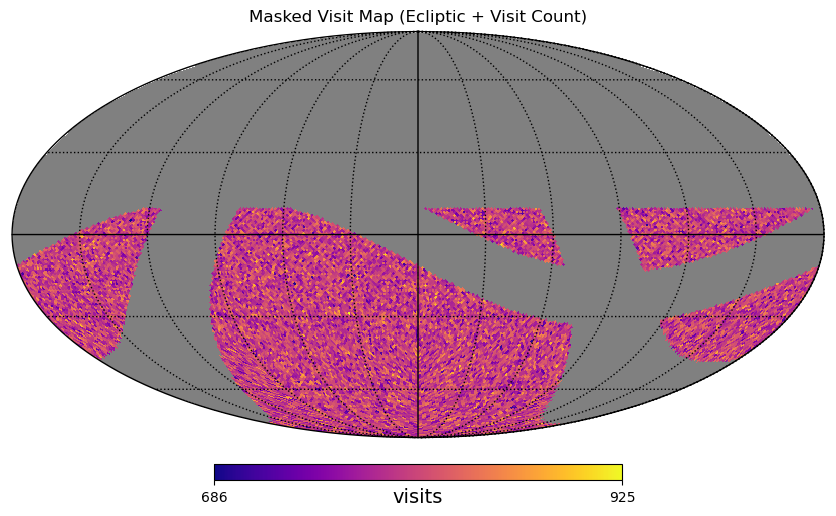

Saved masked cadence with 16914 pixels to 'mock_cadence_masked.pkl'


In [9]:
# RUN THIS CELL

# Combined Ecliptic + Low-Visit Mask — Apply to Saved Cadence and Export


# Load previously saved cadence dictionary
with open('mock_cadence.pkl', 'rb') as f:
    pixel_obs_times = pickle.load(f)

# Rebuild visit_map to apply visit-based masking
visit_map = np.zeros(npix)
for pix in pixel_obs_times:
    for f in pixel_obs_times[pix]:
        visit_map[pix] += len(pixel_obs_times[pix][f])

# Convert to sky coordinates
pix_indices = np.arange(npix)
th, ph = hp.pix2ang(nside, pix_indices)
ra = np.degrees(ph)
dec = np.degrees(0.5 * np.pi - th)

sky_coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Convert to Galactic coordinates
gal_lat = sky_coords.galactic.b.deg
galactic_mask = np.abs(gal_lat) >= 15

# Ecliptic latitude mask (|β| ≥ 10°)
ecl_coords = sky_coords.transform_to(GeocentricTrueEcliptic())
eclip_lat = ecl_coords.lat.deg
ecliptic_mask = np.abs(eclip_lat) >= 10

# Visit count mask (≥ 50 visits)
low_visit_mask = visit_map >= 50

# Combine masks
combined_mask = ecliptic_mask & low_visit_mask & galactic_mask
masked_map = np.copy(visit_map)
masked_map[~combined_mask] = hp.UNSEEN

# Plot masked visit map
hp.mollview(masked_map, title="Masked Visit Map (Ecliptic + Visit Count)", unit='visits', cmap='plasma')
hp.graticule()
plt.show()

# Apply mask to cadence dictionary
pixel_obs_times_masked = {}
for pix in pixel_obs_times:
    if pix < len(combined_mask) and combined_mask[pix]:
        pixel_obs_times_masked[pix] = pixel_obs_times[pix]

# Save masked cadence
with open('mock_cadence_masked.pkl', 'wb') as f:
    pickle.dump(pixel_obs_times_masked, f)

print(f"Saved masked cadence with {len(pixel_obs_times_masked)} pixels to 'mock_cadence_masked.pkl'")


### **Explanation:**

Masking the Galactic and ecliptic planes removes regions where transient detection is unreliable due to crowding or moving objects. Excluding low-visit pixels ensures we only evaluate areas with sufficient cadence for detecting fast-evolving events. This step makes downstream efficiency estimates more realistic and avoids overestimating performance in poorly observed regions.



> **Discussion**: What is a time when you WOULDN'T want to mask the Galactic and/or ecliptic planes? What type of object might you be looking for?

#**3. Light Curve Model and Physical Parameters**

This section creates synthetic kilonova light curves based on key physical parameters (e.g., ejecta mass, viewing angle) and band-dependent light curve characteristics inspired by Bulla models. The resulting templates will later be assigned to injected events.

##**Kilonova Theory**

Kilonovae are optical and near-infrared transients produced by the merger of two compact objects, typically neutron stars. These mergers eject material at high velocities and synthesize heavy elements through r-process nucleosynthesis—powering a rapidly evolving light curve.

### **Ejecta Components**

In this model, we represent kilonovae using two dominant ejecta components:

**Dynamical Ejecta (mej_dyn):** Launched within milliseconds of merger due to tidal forces and shock heating. It is often asymmetric, fast (up to ~0.3c), and neutron-rich—leading to redder emission.

**Wind Ejecta (mej_wind):** Arises from post-merger remnant outflows, including neutrino-driven winds and disk winds. These are slower, more isotropic, and can contain higher electron fractions, producing bluer emission.

### **Geometry and Viewing Angle**

The observed light curve depends heavily on orientation:

* **Opening angle (phi)** defines the angular spread of the ejecta.

* **Viewing angle (theta)** specifies the observer’s line of sight relative to the polar axis.

A viewer near the polar axis may see a brighter, bluer transient due to lower-opacity wind ejecta, while equatorial lines of sight peer through lanthanide-rich dynamical ejecta, dimming and reddening the emission.

**Run the following cell.**

In [10]:
# RUN THIS CELL

# Define a simplified parameter grid (mimicking Bulla's models)

# Define possible values for each parameter
mej_dyn_vals = [0.001, 0.005, 0.01]
mej_wind_vals = [0.01, 0.05, 0.1]
phi_vals = [15, 30, 45]
theta_vals = [0, 30, 60]

# Create parameter combinations
parameter_grid = list(product(mej_dyn_vals, mej_wind_vals, phi_vals, theta_vals))

print(f"Total combinations: {len(parameter_grid)}")


Total combinations: 81


## Challenge Activity 1: Match a Light Curve to Parameters

We use a simplified model where the absolute magnitude is adjusted based on the ejecta masses and geometry:

- Mass of dynamical ejecta (`mej_dyn`)
- Mass of wind ejecta (`mej_wind`)
- Geometry (opening angle `phi`, viewing angle `theta`)

```python
brightness_offset = -1.5 * mej_dyn - 0.5 * mej_wind + 0.01 * (theta / 30.0)
```
This reflects the intuition that:

- **Larger ejecta masses** produce more radioactive heating and thus **brighter transients**.
- **Edge-on viewing angles** reduce observed brightness due to **obscuration** and **higher optical depth**.

The `peak_mag` is the *sum* of the absolute peak magnitudes and the brightness offset.

---

The kilonova light curve is constructed with three key phases:

1. **Rise phase (linear brightening)**  
   `mag = peak_mag - rise_rate * t`

2. **Flat peak (plateau phase)**  
   `mag = peak_mag`

3. **Fade phase (linear dimming)**  
   `mag = peak_mag + fade_rate * (t - duration_peak)`

These components offer a simplified, parameterized view of how brightness evolves with time in each filter.

A kilonova's light curve parameters is shaped by its ejecta mass, geometry, and line of sight. These parameters affect:

- **Rise and fade rates** (in mag/day)  
- **Peak absolute magnitude**  
- **Duration of the peak phase**

These distinctions capture the **wavelength-dependent evolution** of kilonova emission:

- Early **blue emission** (e.g., `g`-band) fades quickly.
- Redder bands (`i`, `z`, `y`) **persist longer** and may dominate at late times.

The design is loosely based on **AT2017gfo**—the first and only kilonova with full multi-band coverage—allowing us to test cadence effectiveness against a realistic benchmark.

**Tasks:** Your task is to implement a function that builds a kilonova light curve using these simplified assumptions.

| Filter | Rise Rate (mag/day) | Fade Rate (mag/day) | Peak Magnitude (abs mag) | Duration at Peak (days) |
|--------|---------------------|----------------------|----------------------------|--------------------------|
| u      | (0.25, 4.75)        | (0.5, 1.8)           | (-15.5, -13.5)             | 0.1                      |
| g      | (0.25, 4.75)        | (0.5, 1.6)           | (-15.5, -14.0)             | 0.3                      |
| r      | (0.5, 4.75)         | (0.4, 1.2)           | (-15.5, -13.0)             | 0.7                      |
| i      | (0.5, 4.75)         | (0.3, 0.9)           | (-16.0, -13.0)             | 1.0                      |
| z      | (0.5, 4.5)          | (0.2, 0.8)           | (-16.0, -13.5)             | 1.5                      |
| y      | (0.25, 4.75)        | (0.2, 0.7)           | (-16.5, -13.5)             | 2.0                      |



In [11]:
print('mej_dyn, mej_wind, phi, theta')
parameter_grid[0]

mej_dyn, mej_wind, phi, theta


(0.001, 0.01, 15, 0)

In [18]:
def generate_kn_lightcurve(mej_dyn, mej_wind, phi, theta, filtername, t_peak=0, t_range=(-1, 7), npts=50, seed=None):
    """
    Generate a simplified kilonova light curve based on physical parameters and filter.

    Parameters:
        mej_dyn : float
            Dynamical ejecta mass in solar masses.
        mej_wind : float
            Wind ejecta mass in solar masses.
        phi : float
            Half-opening angle of ejecta (degrees).
        theta : float
            Viewing angle (degrees).
        filtername : str
            One of 'u', 'g', 'r', 'i', 'z', 'y'.
        t_peak : float
            Time of peak in days.
        t_range : tuple
            Start and end time relative to peak.
        npts : int
            Number of time points.

    Returns:
        t : np.ndarray
            Time array in days.
        mag : np.ndarray
            Apparent magnitude array (no DM or extinction yet).
    """
    # TODO 1: Define rise_rate, fade_rate, peak_abs_mag, duration_peak for each filter
    # Define light curve parameter ranges per filter
    lc_params = {
        'u': {'rise': (0.25, 4.75), 'fade': (0.5, 1.8),  'peak': (-15.5, -13.5),  'dur': 0.1},
        'g': {'rise': (0.25, 4.75), 'fade': (0.5, 1.6),  'peak': (-15.5, -14.0),  'dur': 0.3},
        'r': {'rise': (0.5, 4.75),  'fade': (0.4, 1.2),  'peak': (-15.5, -13.0),  'dur': 0.7},
        'i': {'rise': (0.5, 4.75),  'fade': (0.3, 0.9),  'peak': (-16.0, -13.0),  'dur': 1.0},
        'z': {'rise': (0.5, 4.5),   'fade': (0.2, 0.8),  'peak': (-16.0, -13.5),  'dur': 1.5},
        'y': {'rise': (0.25, 4.75), 'fade': (0.2, 0.7),  'peak': (-16.5, -13.5),  'dur': 2.0},
    }

    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    # Validate filter
    if filtername not in lc_params:
        raise ValueError(f"Unknown filter: {filtername}")

    # Sample parameters from ranges
    p = lc_params[filtername]
    rise_rate = rng.uniform(*p['rise'])         # mag/day
    fade_rate = rng.uniform(*p['fade'])         # mag/day
    peak_mag_abs = rng.uniform(*p['peak'])      # absolute magnitude
    duration_peak = p['dur']                    # fixed per filter

    # TODO 3: Compute brightness offset from mej_dyn, mej_wind, theta
    brightness_offset = -1.5 * mej_dyn - 0.5 * mej_wind + 0.01 * (theta / 30.0)
    peak_mag = peak_mag_abs + brightness_offset

    # Time array
    t = np.linspace(t_range[0], t_range[1], npts)
    t_rel = t - t_peak

    # TODO 4: Construct light curve - fast exponential rise + slower fade
    mag = np.zeros_like(t)
    rise = t_rel < 0
    flat = (t_rel >= 0) & (t_rel <= duration_peak)
    fade = t_rel > duration_peak

    # TODO 5: Define rise, plateau, fade phases
    mag[rise] = peak_mag - rise_rate * t_rel[rise]
    mag[flat] = peak_mag
    mag[fade] = peak_mag + fade_rate * (t_rel[fade] - duration_peak)

    return t, mag

<details>
<summary> SOLUTION </summary>

```python
def generate_kn_lightcurve(mej_dyn, mej_wind, phi, theta, filtername, t_peak=0, t_range=(-1, 7), npts=50):
    """
    Generate a simplified kilonova light curve based on physical parameters and filter.

    Parameters:
        mej_dyn : float
            Dynamical ejecta mass in solar masses.
        mej_wind : float
            Wind ejecta mass in solar masses.
        phi : float
            Half-opening angle of ejecta (degrees).
        theta : float
            Viewing angle (degrees).
        filtername : str
            One of 'u', 'g', 'r', 'i', 'z', 'y'.
        t_peak : float
            Time of peak in days.
        t_range : tuple
            Start and end time relative to peak.
        npts : int
            Number of time points.

    Returns:
        t : np.ndarray
            Time array in days.
        mag : np.ndarray
            Absolute magnitude array (extinction and distance modulus applied during injection).
    """
    # Define light curve parameters per filter
    lc_params = {
        'u': {'rise': 0.25, 'fade': 1.0, 'peak': -14.5, 'dur': 0.1},
        'g': {'rise': 0.75, 'fade': 0.9, 'peak': -14.8, 'dur': 0.3},
        'r': {'rise': 1.0,  'fade': 0.8, 'peak': -14.5, 'dur': 0.7},
        'i': {'rise': 0.8,  'fade': 0.6, 'peak': -14.8, 'dur': 1.0},
        'z': {'rise': 0.7,  'fade': 0.5, 'peak': -14.5, 'dur': 1.5},
        'y': {'rise': 0.6,  'fade': 0.4, 'peak': -14.8, 'dur': 2.0},
    }

    # Validate filter
    if filtername not in lc_params:
        raise ValueError(f"Unknown filter: {filtername}")

    # Fetch light curve shape parameters
    p = lc_params[filtername]
    rise_rate = p['rise']
    fade_rate = p['fade']
    peak_mag_abs = p['peak']
    duration_peak = p['dur']

    # Parameter-based brightness adjustment (toy model)
    theta_factor = 0.01 * (theta / 30.0)
    brightness_offset = -1.5 * mej_dyn - 0.5 * mej_wind + theta_factor
    peak_mag = peak_mag_abs + brightness_offset  # absolute magnitude only

    # Time array
    t = np.linspace(t_range[0], t_range[1], npts)
    t_rel = t - t_peak

    # Construct light curve shape
    mag = np.zeros_like(t_rel)
    rise = t_rel < 0
    flat = (t_rel >= 0) & (t_rel <= duration_peak)
    fade = t_rel > duration_peak

    mag[rise] = peak_mag - rise_rate * t_rel[rise]  # rising
    mag[flat] = peak_mag                            # plateau
    mag[fade] = peak_mag + fade_rate * (t_rel[fade] - duration_peak)  # fading

    return t, mag
```

In [19]:
# RUN THIS CELL

# ------------------------------------------------------------
# Generate KNe Template Library
# ------------------------------------------------------------
def generateKNeTemplates(save_as='KNe_templates.pkl', filters=['u', 'g', 'r', 'i', 'z', 'y'], verbose=True):
    mej_dyn_vals = [0.001, 0.005, 0.01]
    mej_wind_vals = [0.01, 0.05, 0.1]
    phi_vals = [15, 30, 45]
    theta_vals = [0, 30, 60]

    parameter_grid = list(product(mej_dyn_vals, mej_wind_vals, phi_vals, theta_vals))

    templates = []
    for idx, (mej_dyn, mej_wind, phi, theta) in enumerate(parameter_grid):
        entry = {
            'params': {
                'mej_dyn': mej_dyn,
                'mej_wind': mej_wind,
                'phi': phi,
                'theta': theta
            },
            'lightcurve': {}
        }
        for f in filters:
            t, mag = generate_kn_lightcurve(mej_dyn, mej_wind, phi, theta, f)
            entry['lightcurve'][f] = {'t': t, 'mag': mag}
        templates.append(entry)

        if verbose and (idx % 10 == 0):
            print(f"Generated template {idx+1}/{len(parameter_grid)}")

    with open(save_as, 'wb') as f:
        pickle.dump(templates, f)

    print(f"\n Saved {len(templates)} kilonova templates to '{save_as}'.")



In [20]:
# RUN THIS CELL

#Example usage
generateKNeTemplates()

Generated template 1/81
Generated template 11/81
Generated template 21/81
Generated template 31/81
Generated template 41/81
Generated template 51/81
Generated template 61/81
Generated template 71/81
Generated template 81/81

 Saved 81 kilonova templates to 'KNe_templates.pkl'.


> **Discussion**: What type of object is `lc_params`? Why is this a useful format to store those values?

#**Part 2: Plotting Light Curves**

Now that we’ve generated a library of kilonova light curves across different physical parameters, let’s explore how those parameters affect the light curve appearance.

Each template was generated using combinations of:
- **Dynamical ejecta mass** (`mej_dyn`)
- **Wind ejecta mass** (`mej_wind`)
- **Opening angle** (`phi`)
- **Viewing angle** (`theta`)

In this activity, you will:
1. Load the precomputed light curve templates.
2. Select a few individual examples.
3. Plot their light curves in different filters.
4. Observe how the peak brightness, timescale, and color evolution differ.

Loaded 81 kilonova templates.


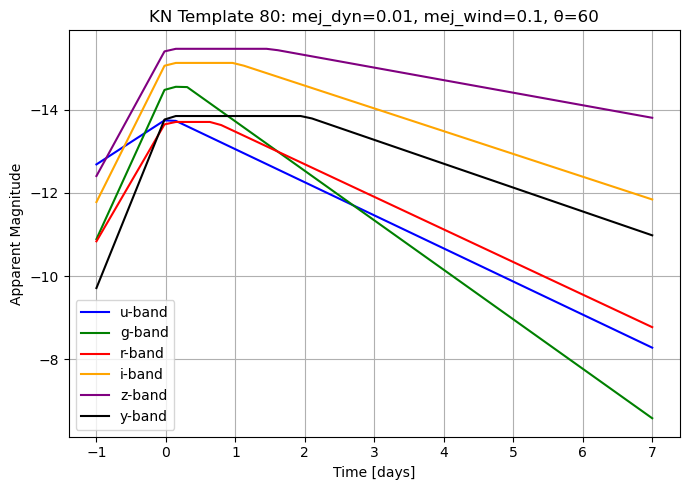

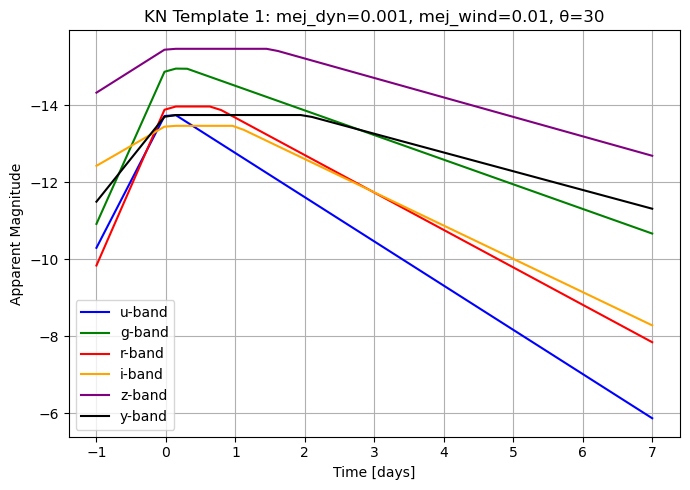

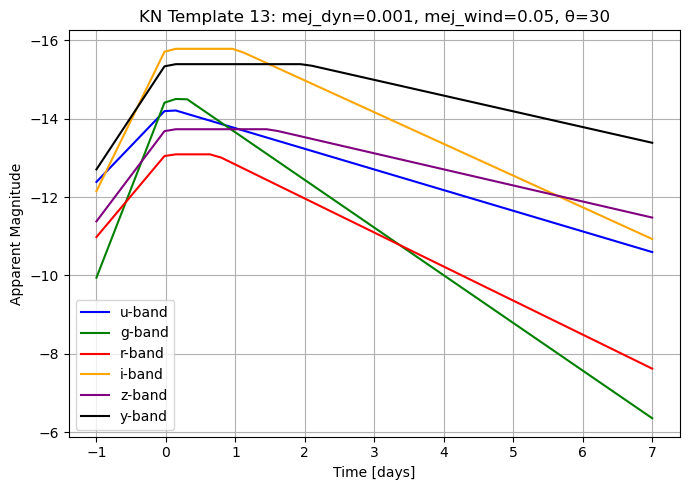

In [21]:
# STEP 1: Load your template library
with open('KNe_templates.pkl', 'rb') as f:
    kne_templates = pickle.load(f)

print(f"Loaded {len(kne_templates)} kilonova templates.")

# STEP 2: Select 3 template indices to examine (or pick randomly!)
example_indices = [80, 1, 13]  # You can change these

# STEP 3: Plot light curves for each filter
filter_colors = {
    'u': 'blue',
    'g': 'green',
    'r': 'red',
    'i': 'orange',
    'z': 'purple',
    'y': 'black'
}

for idx in example_indices:
    template = kne_templates[idx]
    params = template['params']
    lc_data = template['lightcurve']

    plt.figure(figsize=(7, 5))
    for f in filters:
        t = lc_data[f]['t']
        mag = lc_data[f]['mag']
        plt.plot(t, mag, label=f"{f}-band", color=filter_colors[f])

    title_str = f"KN Template {idx}: mej_dyn={params['mej_dyn']}, mej_wind={params['mej_wind']}, θ={params['theta']}"
    plt.gca().invert_yaxis()
    plt.xlabel("Time [days]")
    plt.ylabel("Apparent Magnitude")
    plt.title(title_str)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<details>
<summary> SOLUTION </summary>

```python

# STEP 1: Load your template library
with open('KNe_templates.pkl', 'rb') as f:
    kne_templates = pickle.load(f)

print(f"Loaded {len(kne_templates)} kilonova templates.")

# STEP 2: Select 3 template indices to examine (or pick randomly!)
example_indices = [0, 17, 31]  # You can change these

# STEP 3: Plot light curves from each in r-, i-, and z-band
for idx in example_indices:
    template = kne_templates[idx]
    params = template['params']
    lc_data = template['lightcurve']

    plt.figure(figsize=(7, 5))
    for f in ['r', 'i', 'z']:
        t = lc_data[f]['t']
        mag = lc_data[f]['mag']
        plt.plot(t, mag, label=f"{f}-band")

    title_str = f"KN Template {idx}: mej_dyn={params['mej_dyn']}, mej_wind={params['mej_wind']}, θ={params['theta']}"
    plt.gca().invert_yaxis()
    plt.xlabel("Days Since Peak")
    plt.ylabel("Apparent Magnitude")
    plt.title(title_str)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
```

### **Explanation:**

This synthetic light curve reflects realistic KNe timescales:
- Rapid rise (∼1 mag/day)
- Slower decline (∼0.3–0.5 mag/day)
- Multi-filter variation (e.g., r and i peak at slightly different times)

This activity mirrors the interpretation step astronomers perform before formalizing selection metrics. Having a sense of the shape of light curve, and variation within that shape, informs the selection criteria you use to assess whether a light curve is a kilonova.



---



---



> **Discussion**: Can you spot which light curves evolve faster? Which peak is brighter in the redder filters?





#**4. Informing Detection and Characterization Criteria**

We define filtering rules that help distinguish kilonovae from other fast transients based on their light curve behavior. There are four main "filters" that we use:

* what signal-to-noise ratio we require for a
detection
* how many detections we need to have of one transient
* how rapidly the transient rises to its peak magnitude
* how rapidly the transient fades after reaching its peak magnitude
---
###**Detection Criteria: What Counts as Seen?**
A **kilonova** is considered detected if it meets the following:

**Minimum number of detections:** Often set to 1–2 above a certain SNR.

**Filter requirements:** A detection must occur in specific bands (e.g., ‘r’) to count.

**Time window consistency:** Observations must occur within a plausible temporal window for the transient (e.g., before it fades away).

These criteria are grounded in real survey cadence limitations and the nature of kilonova evolution: fast rise, fast fade, and strong wavelength dependence.

###**Characterization Criteria: What’s Beyond Detection?**
Detecting a transient isn’t enough, we want to understand what it is. For kilonovae, characterization involves capturing parts of the light curve that help distinguish it from other fast transients.

**For this demo, we define characterization as:**

A rise rate ≥ 0.3 mag/day

A fade rate ≥ 0.1 mag/day

These thresholds were chosen to capture the rapid evolution of kilonovae across their peak. The logic is: if the observations allow you to measure both a fast rise and fast fade, then you likely saw enough of the light curve to recognize it as a kilonova.

---
---

###**Signal-to-Noise Ratio (SNR): Why It Matters**
The Signal-to-Noise Ratio is a fundamental concept in observational astronomy. It quantifies how confidently we can say an observed signal (a transient event like a kilonova) stands out against background noise.

---


In [ ]:
# RUN THIS CELL

def m52snr(mag, limmag):
    """
    Approximate signal-to-noise ratio based on magnitude and 5-sigma limiting magnitude.

    Parameters:
        mag : float or np.ndarray
            Apparent magnitude of the source.
        limmag : float or np.ndarray
            5-sigma limiting magnitude of the observation.

    Returns:
        snr : float or np.ndarray
            Signal-to-noise ratio estimate.
    """
    snr = 5.0 * 10.0 ** (-0.4 * (mag - limmag))
    return snr


---
## Challenge Activity: Build a Custom Detection Function

Now that you've adjusted detection criteria using the widgets above, let's test your logic in code!

Your goal is to define a function that takes in a synthetic light curve and determines whether it satisfies the constraints you've set. Specifically, your function should:

1. Check that the light curve has **at least `N` detections above the SNR threshold**.
2. Confirm that **at least one detection occurs in each selected filter**.
3. Optionally verify that the **rise and fade rates fall within your defined range**.


---

Use the following scientific criteria to create two separate functions:

#### Detection Criteria (based on `multi_detect` from Andreoni+ 2022):
- Must have **at least 2 detections** in any filter.
- Detections must be **separated by >15 minutes**.
- Optionally require both detections in:
  - Blue filters (u, g, r) --> for blue kilonova
  - Red filters (i, z, y) --> for red kilonova

#### Characterization Criteria (based on `ztfrest_simple` from Andreoni+ 2022):
- Must have **2 detections in the same filter**,
- Detections separated by **>15 minutes**, AND
- Measured **rise rate > 1 mag/day** and **fade rate > 0.3 mag/day**

**Function Signature Suggestion:**
```python
def passes_detection(lightcurve, snr_thresh, min_detections, required_filters, rise_min, fade_max):
    ...
    return True or False
```
```python
def passes_characterization(lightcurve, rise_thresh, fade_thresh):
    return True or False
```

Feel free to add other features such as printing which conditions failed!

In [ ]:
# YOUR CODE HERE

def passes_detection(lightcurve, snr_thresh=3.0, min_detections=2, required_filters=['r', 'i'], time_sep_min=15/1440.0):
    """
    Determine if a light curve meets detection criteria.

    Parameters:
        lightcurve : dict
            Keys include 'mjd', 'filter', 'mag', 'limmag'
        snr_thresh : float
            Minimum SNR for a valid detection
        min_detections : int
            Minimum number of valid detections
        required_filters : list
            Filters in which at least one detection is required
        time_sep_min : float
            Minimum time separation between detections (in days)

    Returns:
        bool
            True if detection criteria are satisfied
    """
    # Step 1: Compute SNR for all points
    # Use m52snr(lightcurve['mag'], lightcurve['limmag']) > snr_thresh

    # Step 2: Apply SNR cut and get indices of valid detections
    # valid = snr > snr_thresh

    # Step 3: Check number of detections
    # if len(valid_detections) < min_detections: return False

    # Step 4: Check time separation between detections (>15 minutes)
    # Hint: use np.diff(sorted_mjd) > time_sep_min

    # Step 5: Check required filters
    # Are all required_filters represented among valid detections?

    return False  # placeholder until logic is complete




<details>
<summary> SOLUTION </summary>

```python
def passes_detection(lightcurve, snr_thresh=3.0, min_detections=2, required_filters=['r','i'], time_gap_min=0.0105):
    """
    Check if an event passes the kilonova detection criteria.

    Parameters:
        lightcurve : dict
            Contains 'mjd', 'mag', 'limmag', 'filter' for one transient.
        snr_thresh : float
            Minimum signal-to-noise for a detection (e.g., 5).
        min_detections : int
            Minimum number of detections with SNR above threshold.
        required_filters : list
            Filters that must each have at least one detection.
        time_gap_min : float
            Minimum spacing (in days) between any two valid detections (~15 minutes = 0.0105 days).

    Returns:
        bool : True if detection criteria are met.
    """
    # Compute SNR
    snr = m52snr(lightcurve['mag'], lightcurve['limmag'])

    # Identify detections above threshold
    valid = snr >= snr_thresh
    if np.sum(valid) < min_detections:
        return False

    # Check for detections separated by at least 15 min
    mjds = np.array(lightcurve['mjd'])[valid]
    if len(mjds) < 2:
        return False
    if np.all(np.diff(np.sort(mjds)) < time_gap_min):
        return False

    # Filter coverage
    filters_used = set(np.array(lightcurve['filter'])[valid])
    if not set(required_filters).issubset(filters_used):
        return False

    return True
```

In [ ]:
#YOUR CODE HERE

def passes_characterization(lightcurve, rise_thresh=1.0, fade_thresh=0.3, time_sep_min=15/1440.0):
    """
    Determine if a light curve meets characterization criteria.

    Parameters:
        lightcurve : dict
            Keys include 'mjd', 'filter', 'mag'
        rise_thresh : float
            Minimum rise slope in mag/day
        fade_thresh : float
            Minimum fade slope in mag/day
        time_sep_min : float
            Minimum time separation between detections (in days)

    Returns:
        bool
            True if characterization criteria are satisfied
    """
    # Step 1: Identify filters with ≥2 detections
    # For each filter, group MJDs and mags by filter

    # Step 2: For filters with enough detections, check if any pairs are >15 min apart

    # Step 3: Estimate rise and fade slopes
    # Identify peak index, compute linear slope before/after using mag vs mjd

    # Step 4: Check if rise > rise_thresh and fade > fade_thresh

    return False  # placeholder until logic is complete



<details>
<summary> SOLUTION </summary>

```python
def passes_characterization(lightcurve, rise_thresh=1.0, fade_thresh=0.3, time_gap_min=0.0105):
    """
    Check if an event passes characterization criteria.

    Parameters:
        lightcurve : dict
            Contains 'mjd', 'mag', 'filter' for one transient.
        rise_thresh : float
            Minimum rise rate in mag/day.
        fade_thresh : float
            Minimum fade rate in mag/day.
        time_gap_min : float
            Minimum spacing between points to trust slope estimate (~15 minutes).

    Returns:
        bool : True if rise/fade slopes can be measured and meet thresholds.
    """
    filters = np.unique(lightcurve['filter'])

    for f in filters:
        mask = np.array(lightcurve['filter']) == f
        if np.sum(mask) < 2:
            #print(f"Filter {f}: <2 data points")
            continue

        t = np.array(lightcurve['mjd'])[mask]
        m = np.array(lightcurve['mag'])[mask]

        if len(t) < 2:
            #print(f"Filter {f}: insufficient time points")
            continue

        idx = np.argsort(t)
        t = t[idx]
        m = m[idx]

        peak_idx = np.argmin(m)
        if peak_idx == 0 or peak_idx == len(m) - 1:
            #print(f"Filter {f}: Peak at edge (idx={peak_idx}, N={len(m)})")
            continue

        # Rise slope
        t_rise = t[:peak_idx+1]
        m_rise = m[:peak_idx+1]
        dt_rise = np.diff(t_rise)
        dm_rise = -np.diff(m_rise)
        valid_rise = dt_rise >= time_gap_min
        if not np.any(valid_rise):
            #print(f"Filter {f}: No valid rise slopes (dt < {time_gap_min})")
            continue
        rise_rate = np.max(dm_rise[valid_rise] / dt_rise[valid_rise])

        # Fade slope
        t_fade = t[peak_idx:]
        m_fade = m[peak_idx:]
        dt_fade = np.diff(t_fade)
        dm_fade = np.diff(m_fade)
        valid_fade = dt_fade >= time_gap_min
        if not np.any(valid_fade):
            #print(f"Filter {f}: No valid fade slopes (dt < {time_gap_min})")
            continue
        fade_rate = np.max(dm_fade[valid_fade] / dt_fade[valid_fade])

        #print(f"Filter: {f}, Rise: {rise_rate:.2f}, Fade: {fade_rate:.2f}")
        if rise_rate >= rise_thresh and fade_rate >= fade_thresh:
            return True

    return False
```



###**Explanation:**

 Informed constraints sharpen classification accuracy, reduce false positives, and align filter logic with physical models.

 SNR ≥ 5 is widely used in astronomy (including the LSST) as the threshold for a robust detection. This ensures a false positive rate < 1 in 1.7 million per observation under Gaussian noise.

However, when using simulated light curves in a controlled metric environment—like here, we may relax the SNR threshold (e.g., to 3σ) to evaluate broader detection possibilities and edge cases.

In other words, Rubin’s 5σ cut is optimized for real-world survey reliability. In contrast, we may lower the bar in simulation to understand where we start to lose sensitivity.


> **Discussion**: Based on the light curves you looked at earlier, what parameter ranges for characterization criteria seem reasonable to you?

#**5. Generating a Transient Population**

In this section, we simulate a population of kilonova-like events by placing them across the sky and assigning each one a light curve. This allows us to later evaluate how many would be detectable by a given survey cadence.

Typically, we will use a volumetric event rate to estimate how many events would occur in our survey footprint and timespan.

However, for this exercise we are going to inject a set number of events, `n_events`. Feel free to change this to see how detection is affected.

In [ ]:
# RUN THIS CELL

# Load masked cadence file from Section 2
with open("mock_cadence_masked.pkl", "rb") as f:
    pixel_obs_times = pickle.load(f)

# Load template light curves from Section 3
with open("KNe_templates.pkl", "rb") as f:
    templates = pickle.load(f)

def inject_uniform_healpix(nside, n_events, seed=42):
    npix = hp.nside2npix(nside)
    rng = np.random.default_rng(seed)
    pix = rng.choice(npix, size=n_events)
    theta, phi = hp.pix2ang(nside, pix)
    ra = np.degrees(phi)
    dec = np.degrees(0.5 * np.pi - theta)
    return ra, dec, pix


In [ ]:
#YOUR CODE HERE

def generate_KNe_population(n_events=2000, mjd_range=(60980.5, 64633), limmag_mean=24.5, limmag_std=0.3,
                            distance_bounds=(30, 250)):
    sfd = SFDQuery()
    pop = []
    meta = {
        'ra': [], 'dec': [], 'dist': [], 'ebv': [],
        'template_idx': [], 'peak_time': [],
        'detected': [], 'characterized': []
    }

    any_detected = 0
    any_characterized = 0

    ra_all, dec_all, pix_all = inject_uniform_healpix(nside=64, n_events=n_events)

    for i in range(n_events):
        ra = ra_all[i]
        dec = dec_all[i]
        pix = pix_all[i]

        coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')

        # STEP 1: Compute the extinction using `sfd(coord)`
        ebv = ...

        # STEP 2: Randomly sample a distance in Mpc between 30–250
        dist = ...

        # STEP 3: Compute the distance modulus using dist
        dm = ...

        # STEP 4: Randomly sample a peak time between mjd_range[0] and mjd_range[1]
        t_peak = ...

        # Sample template
        template_idx = np.random.randint(0, len(templates))
        template = templates[template_idx]['lightcurve']

        lc_event = {'mjd': [], 'mag': [], 'limmag': [], 'filter': []}

        for f in template:
            if pix not in pixel_obs_times or f not in pixel_obs_times[pix]:
                continue

            t_rel = template[f]['t']
            m = template[f]['mag']
            A_lambda = {'u': 4.9, 'g': 3.7, 'r': 2.7, 'i': 2.0, 'z': 1.5, 'y': 1.3}[f] * ebv
            m_app = m + dm + A_lambda

            for t_obs in pixel_obs_times[pix][f]:
                dt = t_obs - t_peak
                if dt < t_rel[0] or dt > t_rel[-1]:
                    continue
                idx = np.searchsorted(t_rel, dt)
                if idx >= len(m_app): continue
                mag = m_app[idx]
                limmag = np.random.normal(limmag_mean, limmag_std)

                if not np.isfinite(mag):
                    continue

                lc_event['mjd'].append(t_obs)
                lc_event['mag'].append(mag)
                lc_event['limmag'].append(limmag)
                lc_event['filter'].append(f)

        for k in lc_event:
            lc_event[k] = np.array(lc_event[k])

        # Evaluate detection/characterization
        snr = m52snr(lc_event['mag'], lc_event['limmag']) if len(lc_event['mag']) > 0 else np.array([])
        detected = False
        characterized = False

        if len(snr) > 0:
            detected = passes_detection(
                lc_event,
                snr_thresh=3.0,
                min_detections=1,
                required_filters=['r']
            )
            characterized = passes_characterization(
                lc_event,
                rise_thresh=0.3,
                fade_thresh=0.1
            ) if detected else False

        if detected:
            any_detected += 1
        if characterized:
            any_characterized += 1

        pop.append(lc_event)
        meta['ra'].append(ra)
        meta['dec'].append(dec)
        meta['dist'].append(dist)
        meta['ebv'].append(ebv)
        meta['template_idx'].append(template_idx)
        meta['peak_time'].append(t_peak)
        meta['detected'].append(detected)
        meta['characterized'].append(characterized)

    print(f"\nOut of {n_events} events:")
    print(f"  {any_detected} were detected")
    print(f"  {any_characterized} were characterized")

    return pop, meta


<details>
<summary> SOLUTION </summary>

```python
def inject_uniform_healpix(nside, n_events, seed=42):
    npix = hp.nside2npix(nside)
    rng = np.random.default_rng(seed)
    pix = rng.choice(npix, size=n_events)
    theta, phi = hp.pix2ang(nside, pix)
    ra = np.degrees(phi)
    dec = np.degrees(0.5 * np.pi - theta)
    return ra, dec, pix

def generate_KNe_population(n_events=2000, mjd_range=(60980.5, 64633), limmag_mean=24.5, limmag_std=0.3,
                            distance_bounds=(30, 250)):
    sfd = SFDQuery()
    pop = []
    meta = {
        'ra': [], 'dec': [], 'dist': [], 'ebv': [],
        'template_idx': [], 'peak_time': [],
        'detected': [], 'characterized': []
    }

    any_detected = 0
    any_characterized = 0
    
    ra_all, dec_all, pix_all = inject_uniform_healpix(nside=64, n_events=n_events)

    for i in range(n_events):
        ra = ra_all[i]
        dec = dec_all[i]
        pix = pix_all[i]

        coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
        ebv = sfd(coord)
        dist = np.random.uniform(*distance_bounds)
        dm = 5 * np.log10(dist * 1e6) - 5

        template_idx = np.random.randint(0, len(templates))
        template = templates[template_idx]['lightcurve']
        t_peak = np.random.uniform(*mjd_range)

        lc_event = {'mjd': [], 'mag': [], 'limmag': [], 'filter': []}

        for f in template:
            if pix not in pixel_obs_times or f not in pixel_obs_times[pix]:
                continue

            t_rel = template[f]['t']
            m = template[f]['mag']
            A_lambda = {'u': 4.9, 'g': 3.7, 'r': 2.7, 'i': 2.0, 'z': 1.5, 'y': 1.3}[f] * ebv
            m_app = m + dm + A_lambda

            for t_obs in pixel_obs_times[pix][f]:
                dt = t_obs - t_peak
                if dt < t_rel[0] or dt > t_rel[-1]:
                    continue
                idx = np.searchsorted(t_rel, dt)
                if idx >= len(m_app): continue
                mag = m_app[idx]
                limmag = np.random.normal(limmag_mean, limmag_std)

                if not np.isfinite(mag):
                    continue

                lc_event['mjd'].append(t_obs)
                lc_event['mag'].append(mag)
                lc_event['limmag'].append(limmag)
                lc_event['filter'].append(f)

        for k in lc_event:
            lc_event[k] = np.array(lc_event[k])

        # Evaluate detection/characterization
        snr = m52snr(lc_event['mag'], lc_event['limmag']) if len(lc_event['mag']) > 0 else np.array([])
        detected = False
        characterized = False

        if len(snr) > 0:
            detected = passes_detection(
                lc_event,
                snr_thresh=3.0,
                min_detections=1,
                required_filters=['r']
            )
            characterized = passes_characterization(
                lc_event,
                rise_thresh=0.3,
                fade_thresh=0.1
            ) if detected else False

        if detected:
            any_detected += 1
        if characterized:
            any_characterized += 1

        pop.append(lc_event)
        meta['ra'].append(ra)
        meta['dec'].append(dec)
        meta['dist'].append(dist)
        meta['ebv'].append(ebv)
        meta['template_idx'].append(template_idx)
        meta['peak_time'].append(t_peak)
        meta['detected'].append(detected)
        meta['characterized'].append(characterized)

    print(f"\nOut of {n_events} events:")
    print(f"  {any_detected} were detected")
    print(f"  {any_characterized} were characterized")

    return pop, meta

```

###**Explanation:**

This is where everything we've set up: light curves, extinction, survey depth, and observation times...starts to come together. By putting those pieces into a single population generator, we’re getting ready to test our detection and characterization logic in a way that actually reflects what Rubin would see on the sky.

Even though we haven’t run the generator yet, the way we define `generate_KNe_population()` is technically important. It encodes our assumptions about what kilonovae look like and how they interact with Rubin’s observing pattern. The structure also lets us swap in different cadence files, change physical parameters, or update detection thresholds without rewriting the entire pipeline.

This is where we move from theory into simulation: we're no longer describing what kilonovae might do. We're programming what they would do in the sky and letting Rubin observe them.


> **Discussion**: What parameters are included in your kilonova models? Why are each of them necessary in order to determine whether the kilonovae are detected or not?

#**6. Applying: Population Injection and Recovery Testing**

Now we put our population generator to use. This is the point where simulated kilonovae are dropped across the sky and tested against Rubin’s observations—filter by filter, epoch by epoch.

The logic here mirrors how real-time transient pipelines work:

**1. Inject Events:**
Each event is assigned a light curve and injected into a realistic observing field using a uniform sky distribution.

**2. First Pass – Detection:**
We check if Rubin would have caught the event based on signal-to-noise, cadence sampling, and filter coverage. This step filters out events that wouldn’t make it past an alert threshold in a live survey.

**3. Second Pass – Characterization:**
For the events that were detected, we assess whether the light curve has enough information to distinguish the source as kilonova-like. That means checking for rise/fade behavior, time coverage, and multi-filter support—conditions needed to extract physical insight.

By staging it this way, we avoid spending resources analyzing events Rubin didn’t really observe. It also gives a fairer test of cadence performance! We’re not asking if Rubin could detect everything, but whether it can detect and characterize what matters.

In [ ]:
# Generate and evaluate population
kne_pop, kne_meta = generate_KNe_population()

# === Sky Map Efficiency Plot (Detection and Characterization) ===

nside = 64
npix = hp.nside2npix(nside)

# Convert RA/Dec to HEALPix pixel indices
coords = SkyCoord(ra=np.array(kne_meta['ra']) * u.deg,
                  dec=np.array(kne_meta['dec']) * u.deg, frame='icrs')
pix_indices = hp.ang2pix(nside, 0.5 * np.pi - coords.dec.radian, coords.ra.radian)

# Initialize per-pixel counts
injected_map = np.zeros(npix)
detected_map = np.zeros(npix)
characterized_map = np.zeros(npix)

for i, pix in enumerate(pix_indices):
    injected_map[pix] += 1
    if kne_meta['detected'][i]:
        detected_map[pix] += 1
    if kne_meta['characterized'][i]:
        characterized_map[pix] += 1

# Efficiency maps
det_eff_map = np.zeros(npix) + hp.UNSEEN
char_eff_map = np.zeros(npix) + hp.UNSEEN

valid_pix = injected_map > 0
det_eff_map[valid_pix] = detected_map[valid_pix] / injected_map[valid_pix]
char_eff_map[valid_pix] = characterized_map[valid_pix] / injected_map[valid_pix]

# Detection Efficiency
hp.mollview(det_eff_map,
            title='KNe Detection Efficiency',
            unit='Efficiency',
            cmap='viridis',  #
            min=0, max=1)
hp.graticule()
plt.show()

# Characterization Efficiency
hp.mollview(char_eff_map,
            title='KNe Characterization Efficiency',
            unit='Efficiency',
            cmap='viridis',
            min=0, max=1)
hp.graticule()
plt.show()

## **Explanation:**

These Healpix maps show detection and characterization efficiency across the sky. Areas with higher values are where Rubin's cadence aligns well with our transient models, giving us reliable recovery. Gaps and low-efficiency regions often trace the limits of the LSST footprint or areas with fewer visits in relevant filters.

These maps help answer key questions:

Is the cadence leaving large regions of the sky under-sampled?

Are certain declinations or right ascensions better covered than others?

Where might we need deeper coverage, better filter cadence, or faster revisit times?

This type of spatial efficiency mapping is crucial when evaluating survey strategies for fast transients like kilonovae.

>**Discussion:** What do these maps tell you about the efficacy of the metrics? Of the cadence itself?

#**7. Efficiency Metrics and Final Outputs & Diagnostics**

To evaluate the performance of our kilonova (KNe) detection and characterization metric, we generate a suite of diagnostic visualizations summarizing the spatial, temporal, and photometric distributions of both injected and detected events. These diagnostics enable us to assess how cadence coverage, sky position, and event properties influence detection efficiency.

---

## 7.1 Apparent Magnitude vs RA/Dec

The scatter plots of apparent peak magnitude against Right Ascension (RA) and Declination (Dec) reveal several key features:

Injected events are distributed uniformly across the celestial sphere, with a broad range of peak apparent magnitudes reflecting variation in distance and extinction.

Detected events cluster more narrowly in both sky position and magnitude:

They are typically brighter (lower mag) and more concentrated within regions where Rubin visits are frequent and deep.

The lack of detections at higher declinations or specific RA bands may highlight gaps in cadence coverage or seasonal inaccessibility (e.g., near the Sun).

These plots directly visualize survey selection effects, where the intrinsic KNe population is filtered by the observing strategy.

In [ ]:
# ------------------------------------------
# KNe Diagnostic Scatter Plots (RA/Dec vs mag)
# ------------------------------------------

In [ ]:
# RUN THIS CELL

# Convert to arrays
ras = np.radians(kne_meta['ra'])           # in radians
decs = np.radians(kne_meta['dec'])         # in radians
peak_mags = np.array([np.min(lc['mag']) if len(lc['mag']) > 0 else np.nan for lc in kne_pop])
detected_flags = np.array(kne_meta['detected'])
characterized_flags = np.array(kne_meta['characterized'])

# Plot: Apparent magnitude vs RA
plt.figure(figsize=(8, 4))
plt.scatter(ras, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
plt.scatter(ras[detected_flags], peak_mags[detected_flags],
            c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
plt.xlabel("RA [rad]")
plt.ylabel("Apparent Peak Magnitude")
plt.title("KNe – Apparent Mag vs RA")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Apparent magnitude vs Dec
plt.figure(figsize=(8, 4))
plt.scatter(decs, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
plt.scatter(decs[detected_flags], peak_mags[detected_flags],
            c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
plt.xlabel("Dec [rad]")
plt.ylabel("Apparent Peak Magnitude")
plt.title("KNe – Apparent Mag vs Dec")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 7.2 Detection Efficiency by Declination

The histogram of declinations for injected versus detected events provides a complementary view of the spatial selection bias:

A decline in detections toward high declination (northern sky) is consistent with Rubin's Wide-Fast-Deep (WFD) footprint, which prioritizes the southern celestial hemisphere.

The overlap between injected and detected distributions quantifies the sky coverage efficiency of the survey for this transient class.

In [ ]:
# RUN THIS CELL

# Declination Histogram (deg)
plt.figure(figsize=(8, 4))
plt.hist(np.degrees(decs), bins=50, alpha=0.5, label='Injected')
plt.hist(np.degrees(decs[detected_flags]), bins=50, alpha=0.8, label='Detected', color='red')
plt.xlabel("Declination [deg]")
plt.ylabel("Number of Events")
plt.title("KNe – Declination Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7.3 Temporal Distributions

Two sets of histograms track the distribution of peak times:

The peak MJD histogram shows that injection is uniformly distributed in time, as expected from the random sampling over the 10-year survey.

The survey year histogram and the detection-per-year histogram allow us to assess detection efficiency over time:

Detection counts roughly track injected events per year, but any discrepancies (e.g., dips in certain years) may reflect cadence gaps, camera downtime, or reduced depth due to observing conditions.

This is particularly relevant for fast-evolving transients like KNe, which are highly sensitive to temporal gaps of even a few days.

In [ ]:
# RUN THIS CELL

# Histogram of peak MJDs
plt.figure(figsize=(8, 4))
plt.hist(kne_meta['peak_time'], bins=20, color='orange', edgecolor='black')
plt.xlabel("Peak MJD")
plt.ylabel("Number of Events")
plt.title("Distribution of KNe Peak Times")
plt.grid(True)
plt.tight_layout()
plt.show()


# Yearly histogram from peak_time
peak_times = np.array(kne_meta['peak_time'])
years = np.floor((peak_times - 60980.5) / 365).astype(int) + 1  # assuming year 1 starts ~MJD 59580
years = np.clip(years, 1, 10)

plt.figure(figsize=(8, 4))
plt.hist(years, bins=np.arange(0.5, 11.5, 1), edgecolor='black')
plt.xticks(ticks=np.arange(1, 11), labels=[f"Year {i}" for i in range(1, 11)])
plt.xlabel("Survey Year")
plt.ylabel("Number of Events")
plt.title("Distribution of Peak Times")
plt.grid(True)
plt.tight_layout()
plt.show()

# Detection histogram per year
det_years = years[detected_flags]
det_counts = np.bincount(det_years, minlength=11)[1:11]

plt.figure(figsize=(8, 4))
plt.bar(np.arange(1, 11), det_counts, width=0.7, align='center', edgecolor='black')
plt.xticks(ticks=np.arange(1, 11), labels=[f"Year {i}" for i in range(1, 11)])
plt.xlabel("Survey Year")
plt.ylabel("Number of Detections")
plt.title("Distribution of DETECTED Peak Times")
plt.grid(True)
plt.tight_layout()
plt.show()





## **Explanation:**

Together, these diagnostics serve several important purposes:

**Sanity Checks:** Confirm that injections span the intended range of parameters and are sampled uniformly in time and sky position.

**Efficiency Interpretation:** Detection and characterization efficiency can be inferred by comparing the number of recovered events to total injections across different sky regions and time intervals.

Cadence Validation: **bold text** These outputs can reveal systematic issues in a cadence (e.g., unobserved regions, gaps in temporal coverage), helping identify areas for optimization.

**Population Constraints:** The distribution of detected peak magnitudes vs. injection depth informs how far into the Universe Rubin can detect kilonovae under current observing strategies.

In sum, these diagnostics not only validate the integrity of the metric implementation but also highlight the regions of parameter space where Rubin is most and least effective at capturing fast optical transients like kilonovae. These outputs directly inform cadence strategy refinement and science yield projections.

> **Discussion**: From each of your diagnostics, how can you tell that your functions are working correctly? What have you learned about how well Rubin can find kilonovae?

#**8. Beyond the Demo: What Real Rubin Sky Maps Look Like**
Everything we've done so far captures the core logic behind transient recovery:

- injecting a population
- simulating light curves
- testing recovery under a survey cadence.

**But, this is just the beginning!**

Below is an example sky map from my GRB afterglow pipeline, `local_GRBafterglows_metric.py.`

Unlike our simplified kilonova demo, that code handles:

- Volumetric population sampling using cosmology (comoving volume and redshift integration)

- Power-law light curves based on afterglow physics (Zeh et al. 2005),

- Realistic Milky Way extinction using dustmaps.SFDQuery,

- Multi-band and multi-epoch detection logic,

- Characterization metrics for triggering, color evolution, and spectroscopic utility.

This map shows detection efficiency across the Rubin sky for GRB afterglows—taking into account years of cadence evolution, band-dependent detection thresholds, and time lags between observations.
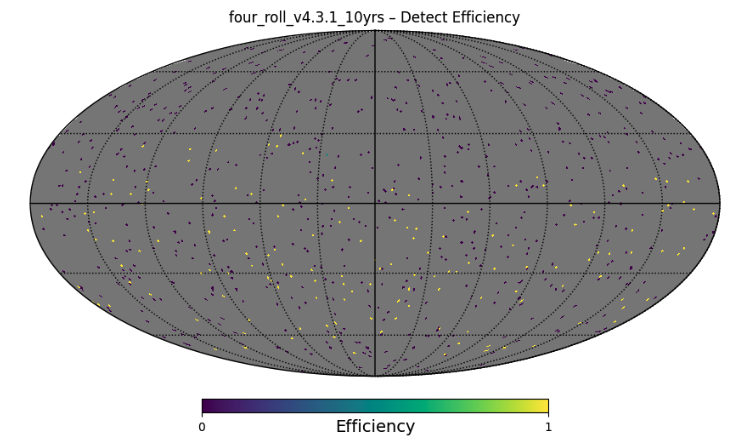

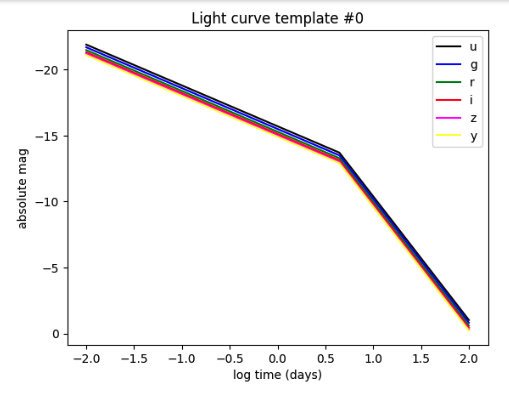

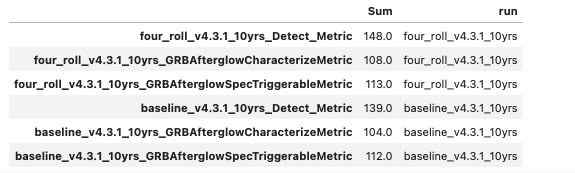